# Skin Disease Classification using CNN and DenseNet201

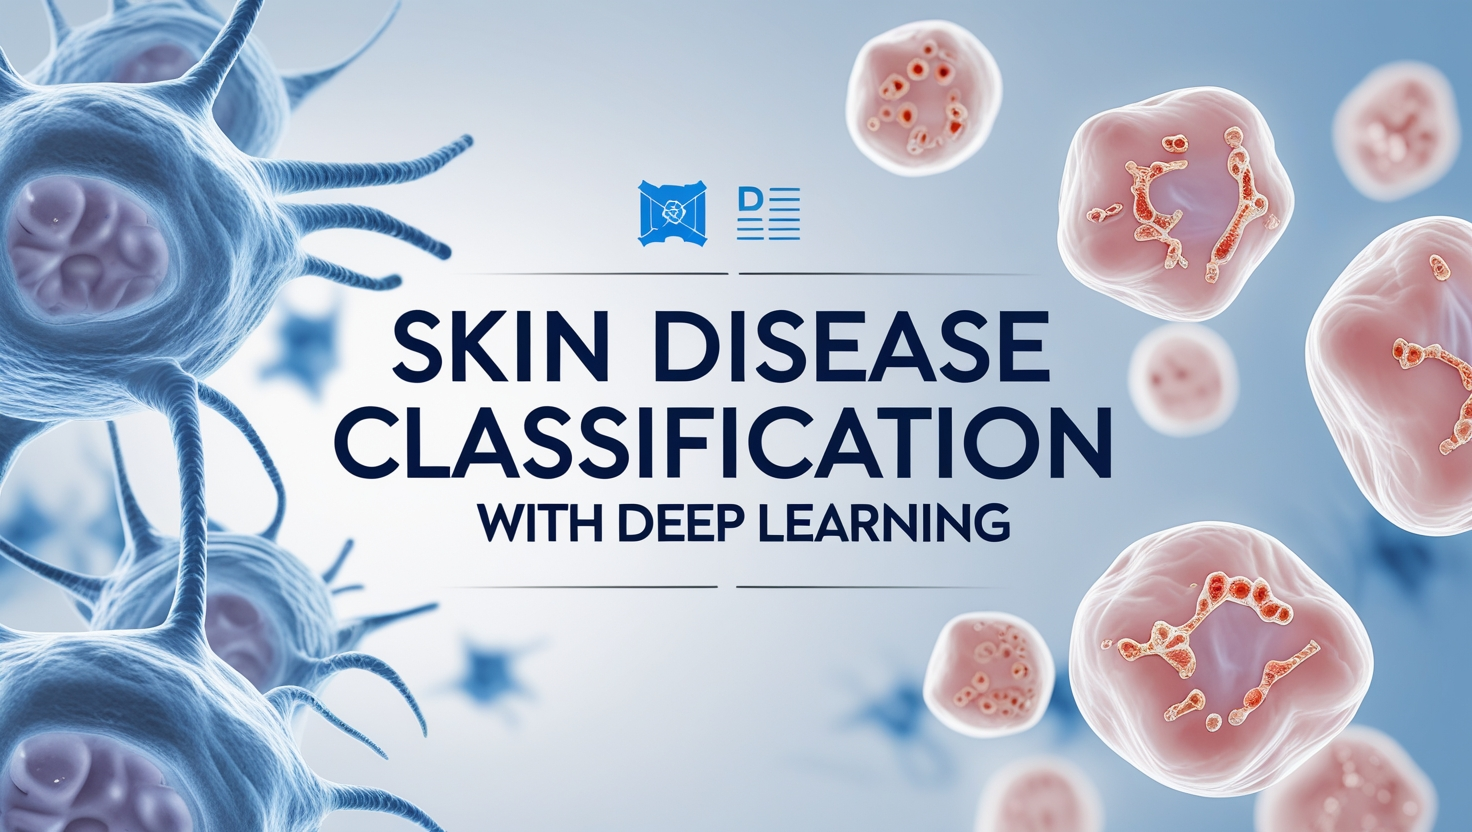

## About the Dataset
This dataset consists of **2,357 images** of malignant and benign skin diseases, derived from **The International Skin Imaging Collaboration (ISIC)**. All images have been categorized according to ISIC classification and organized into balanced subsets, except for melanoma and nevus, which have a slightly higher representation.

### Dataset Details:
- **Source**: [Skin Cancer 9 Classes (ISIC) Dataset](https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic)  
- **Total Images**: 2,357  
- **Classes**:
  - Actinic Keratosis  
  - Basal Cell Carcinoma  
  - Dermatofibroma  
  - Melanoma  
  - Nevus  
  - Pigmented Benign Keratosis  
  - Seborrheic Keratosis  
  - Squamous Cell Carcinoma  
  - Vascular Lesion  

This notebook demonstrates the implementation of **Convolutional Neural Networks (CNN)** and **DenseNet201** for effective classification of these skin diseases.

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical  # Updated import
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# Step No 2 : Importing Data from Input and Creating a Dataframe

In [3]:
def create_dataframe(data_dir):
    data = [
        {"image_path": os.path.join(data_dir, dir_name, fname), "label": label}
        for label, dir_name in enumerate(os.listdir(data_dir))
        for fname in os.listdir(os.path.join(data_dir, dir_name))
    ]
    return pd.DataFrame(data)

train_dir = '/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
test_dir = '/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test'

# Create combined dataframe
df = pd.concat([create_dataframe(train_dir), create_dataframe(test_dir)], ignore_index=True)

In [4]:
df.sample(10)

,image_path,label
2302,/kaggle/input/skin-cancer9-classesisic/Skin ca...,4
1074,/kaggle/input/skin-cancer9-classesisic/Skin ca...,3
170,/kaggle/input/skin-cancer9-classesisic/Skin ca...,0
1926,/kaggle/input/skin-cancer9-classesisic/Skin ca...,8
1929,/kaggle/input/skin-cancer9-classesisic/Skin ca...,8
357,/kaggle/input/skin-cancer9-classesisic/Skin ca...,0
1312,/kaggle/input/skin-cancer9-classesisic/Skin ca...,4
76,/kaggle/input/skin-cancer9-classesisic/Skin ca...,0
395,/kaggle/input/skin-cancer9-classesisic/Skin ca...,0
1882,/kaggle/input/skin-cancer9-classesisic/Skin ca...,8


In [5]:
# Get list of directories and create label_map
label_map = {i: label for i, label in enumerate(os.listdir(train_dir))}
num_classes = len(label_map)
label_map

{0: 'pigmented benign keratosis',
 1: 'melanoma',
 2: 'vascular lesion',
 3: 'actinic keratosis',
 4: 'squamous cell carcinoma',
 5: 'basal cell carcinoma',
 6: 'seborrheic keratosis',
 7: 'dermatofibroma',
 8: 'nevus'}

In [6]:
max_images_per_class = 2000

# Limit each class to max_images_per_class samples
df = df.groupby("label").head(max_images_per_class).reset_index(drop=True)

In [7]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except Exception as e:
    print(e)

import multiprocessing

# Get the number of CPU cores
max_workers = multiprocessing.cpu_count()
print(max_workers)

[]
4


In [8]:
import concurrent.futures
# Function to resize image arrays
def resize_image_array(image_path):
    return np.asarray(Image.open(image_path).resize((100, 75)))

# Parallelize resizing process
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    df['image'] = list(executor.map(resize_image_array, df['image_path']))

In [9]:
# Initialize ImageDataGenerator with transformations
datagen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.5,
    height_shift_range=0.25,
    shear_range=0.25,
    zoom_range=0.25,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [10]:
# Initialize augmented DataFrame
augmented_df = pd.DataFrame(columns=['image_path', 'label', 'image'])

for class_label in df['label'].unique():
    # Get image arrays for the current class
    class_images = df[df['label'] == class_label]
    image_arrays = class_images['image'].values
    num_images_needed = max_images_per_class - len(image_arrays)
    
    # Add original images to augmented DataFrame
    augmented_df = pd.concat([augmented_df, class_images], ignore_index=True)

    if num_images_needed > 0:
        selected_images = np.random.choice(image_arrays, size=num_images_needed, replace=True)
        
        # Augment and add new images
        for img_array in selected_images:
            image_tensor = np.expand_dims(img_array, axis=0)
            augmented_images = datagen.flow(image_tensor, batch_size=1)
            
            for _ in range(1):  # Generate one augmented image at a time
                augmented_img = next(augmented_images)[0].astype('uint8')
                new_row = pd.DataFrame([{'image_path': None, 'label': class_label, 'image': augmented_img}])
                augmented_df = pd.concat([augmented_df, new_row], ignore_index=True)

# Limit the size of each class
df = augmented_df.groupby('label').head(max_images_per_class).sample(frac=1, random_state=42).reset_index(drop=True)

In [11]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the dataset summary
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for label, name in label_map.items():
    print(f"{label:<15} {name:<30} {class_counts[label]:<10}")
print("-" * 60)
print(f"{'Total':<45} {class_counts.sum():<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               pigmented benign keratosis     2000      
1               melanoma                       2000      
2               vascular lesion                2000      
3               actinic keratosis              2000      
4               squamous cell carcinoma        2000      
5               basal cell carcinoma           2000      
6               seborrheic keratosis           2000      
7               dermatofibroma                 2000      
8               nevus                          2000      
------------------------------------------------------------
Total                                         18000     


In [12]:
X = df.drop(columns=['label','image_path'],axis=1)
y = df['label']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,shuffle=True)

In [14]:
# Convert images to numpy arrays
X_train = np.asarray(X_train['image'].tolist())
X_test = np.asarray(X_test['image'].tolist())

# Normalize images
X_train_mean, X_train_std = X_train.mean(), X_train.std()
X_test_mean, X_test_std = X_test.mean(), X_test.std()

X_train = (X_train - X_train_mean) / X_train_std
X_test = (X_test - X_test_mean) / X_test_std

In [15]:
from keras.utils import to_categorical

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

In [16]:
# Split data into training and validation sets
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)

In [17]:
# Reshape images to 3D (height=75px, width=100px, channels=3)
X_train = X_train.reshape(X_train.shape[0], 75, 100, 3)
X_test = X_test.reshape(X_test.shape[0], 75, 100, 3)
X_validate = X_validate.reshape(X_validate.shape[0], 75, 100, 3)

In [18]:
y_train = y_train.astype(int)
y_validate = y_validate.astype(int)

In [19]:
# Count the number of images per class
train_counts = np.sum(y_train, axis=0)
val_counts = np.sum(y_validate, axis=0)
test_counts = np.sum(y_test, axis=0)

# Print dataset summary
print("Dataset Summary")
print("-" * 90)
print(f"{'Class Label':<15} {'Class Name':<30} {'Train':<10} {'Validation':<12} {'Test':<10} {'Total':<10}")
print("-" * 90)
for label, name in label_map.items():
    train_num = int(train_counts[label])
    val_num = int(val_counts[label])
    test_num = int(test_counts[label])
    total_num = train_num + val_num + test_num
    print(f"{label:<15} {name:<30} {train_num:<10} {val_num:<12} {test_num:<10} {total_num:<10}")
print("-" * 90)
total_images = len(y_train) + len(y_validate) + len(y_test)
print(f"{'Total':<46} {len(y_train):<10} {len(y_validate):<12} {len(y_test):<10} {total_images:<10}")

Dataset Summary
------------------------------------------------------------------------------------------
Class Label     Class Name                     Train      Validation   Test       Total     
------------------------------------------------------------------------------------------
0               pigmented benign keratosis     1258       329          413        2000      
1               melanoma                       1296       315          389        2000      
2               vascular lesion                1267       321          412        2000      
3               actinic keratosis              1317       306          377        2000      
4               squamous cell carcinoma        1273       333          394        2000      
5               basal cell carcinoma           1246       348          406        2000      
6               seborrheic keratosis           1297       288          415        2000      
7               dermatofibroma                 1296       

In [20]:
input_shape = df['image'][0].shape
input_shape

(75, 100, 3)

In [21]:
from tensorflow.keras.applications import MobileNetV3Large

In [22]:
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import SGD

In [23]:
# Define the DenseNet201 model with custom layers
model = Sequential([
    DenseNet201(include_top=False, weights='/kaggle/input/weight-file/densenet201_weights_tf_dim_ordering_tf_kernels_notop.h5', input_shape=input_shape),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)             │ (None, 2, 3, 1920)          │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 11520)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 11520)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       5,898,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,225,353 (92.41 MB)

 Trainable params: 23,996,297 (91.54 MB)

 Non-trainable params: 229,056 (894.75 KB)

In [24]:
# Compile the model
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Set learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)

In [25]:
%%time
# Fit the model
history = model.fit(
    X_train, y_train,
    epochs=50, batch_size=32,
    validation_data=(X_validate, y_validate),
    callbacks=[learning_rate_reduction]
)

Epoch 1/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 637s 2s/step - accuracy: 0.3755 - loss: 1.8684 - val_accuracy: 0.6316 - val_loss: 1.0322 - learning_rate: 0.0010
Epoch 2/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 594s 2s/step - accuracy: 0.6490 - loss: 0.9457 - val_accuracy: 0.6865 - val_loss: 0.8584 - learning_rate: 0.0010
Epoch 3/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 608s 2s/step - accuracy: 0.7554 - loss: 0.6495 - val_accuracy: 0.7222 - val_loss: 0.7552 - learning_rate: 0.0010
Epoch 4/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 576s 2s/step - accuracy: 0.8189 - loss: 0.4877 - val_accuracy: 0.7469 - val_loss: 0.7420 - learning_rate: 0.0010
Epoch 5/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 576s 2s/step - accuracy: 0.8665 - loss: 0.3525 - val_accuracy: 0.7837 - val_loss: 0.6463 - learning_rate: 0.0010
Epoch 6/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 575s 2s/step - accuracy: 0.8878 - loss: 0.2923 - val_accuracy: 0.7667 - val_loss: 0.7689 - learning_rate: 0.0010
Epoch 7/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 572s 2s/step - accuracy: 0.9107 - loss: 0.

In [26]:
model.save('/kaggle/working/skin_disease_model.h5')

In [27]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

In [28]:
model = load_model('/kaggle/working/skin_disease_model.h5')

In [29]:
# Define the path to the image
image_path='/kaggle/input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test/nevus/ISIC_0000015.jpg'

# Load the image and preprocess it
img = image.load_img(image_path, target_size=(75, 100))  # Correct order: height=75px, width=100px
img_array = image.img_to_array(img)  # Convert image to array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Normalize the image as per the training data preprocessing
img_array = (img_array - np.mean(img_array)) / np.std(img_array)

In [30]:
# Predict the class
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)

# Map the predicted class index to the class label
predicted_label = label_map[predicted_class[0]]

print(f"Predicted Class: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted Class: nevus
